# AIM

Aim of this Notebook is to evaluate the models we have fine-tuned, we would be using bert-score for evalution

## Note:

* `model_0`: Base model (LLaMA 3.2 3B Instruct)
* `model_1`: Model trained only on the custom dataset
* `model_2`: Model trained on the custom and the TL;DR dataset

In [11]:
import sys
import numpy as np
from pathlib import Path

from json import loads
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import tukey_hsd
from scipy.stats import gaussian_kde

project_root = Path.cwd().parent  # or Path().resolve().parent
sys.path.insert(0, str(project_root))

from src.evaluate import evaluate
from src.utils.batch_utils import data_folder
from src.load_dataset import CS_JSON, load_jsonl, split_90_and_10
from src.load_model import load_tokenizer, count_bart_tokens
from src.eval_model import EXPORT_BASE_RESULTS, EXPORT_CS_RESULTS, EXPORT_CS_TLDR_RESULTS

# Token Counter

Before evaluating the output with the BART model, let's first determine the number of tokens. This will help us understand how many test samples might be truncated during the evaluation process.


## Tokenizer

we would be using [facebook/bart-large](https://huggingface.co/facebook/bart-large) as a model in our bert score so we would be using its tokenizer

In [2]:
# data Files

base_outputs = data_folder / EXPORT_BASE_RESULTS
custom_outputs = data_folder / EXPORT_CS_RESULTS
combined_outputs = data_folder / EXPORT_CS_TLDR_RESULTS
custom_dataset_file = data_folder / CS_JSON

In [3]:
# loading the bart tokenizer
tokenizer = load_tokenizer("facebook/bart-large")

In [4]:
# counts the number of tokens generated by our models

# base model
model0_tokens = [count_bart_tokens(tokenizer, i[-1]) for i in loads(base_outputs.read_text())]
# one fine tuned with only custom dataset
model1_tokens = [count_bart_tokens(tokenizer, i[-1]) for i in loads(custom_outputs.read_text())]
# fine-tuned with tl;dr and custom dataset
model2_tokens = [count_bart_tokens(tokenizer, i[-1]) for i in loads(combined_outputs.read_text())]
exceeded_0 = np.count_nonzero(np.array(model0_tokens) > 1024)
exceeded_1 = np.count_nonzero(np.array(model1_tokens) > 1024)
exceeded_2 = np.count_nonzero(np.array(model2_tokens) > 1024)


Token indices sequence length is longer than the specified maximum sequence length for this model (1538 > 1024). Running this sequence through the model will result in indexing errors


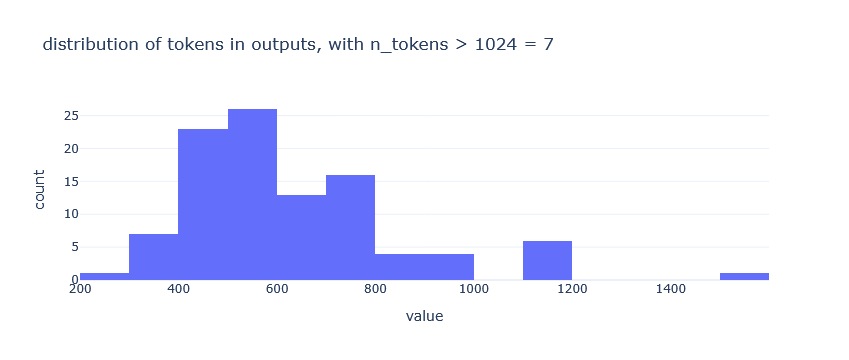

In [19]:
fig = px.histogram(model0_tokens, title=f"distribution of tokens in outputs, with n_tokens > 1024 = {exceeded_0}")
fig.update_layout(showlegend=False, template="plotly_white")
fig

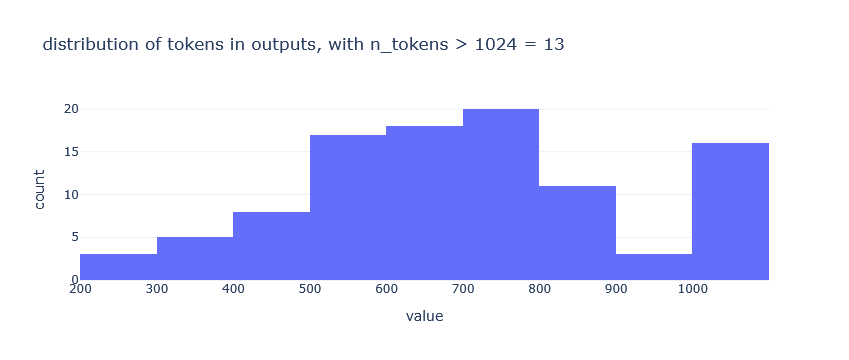

In [20]:
fig = px.histogram(model1_tokens, title=f"distribution of tokens in outputs, with n_tokens > 1024 = {exceeded_1}")
fig.update_layout(showlegend=False, template="plotly_white")
fig

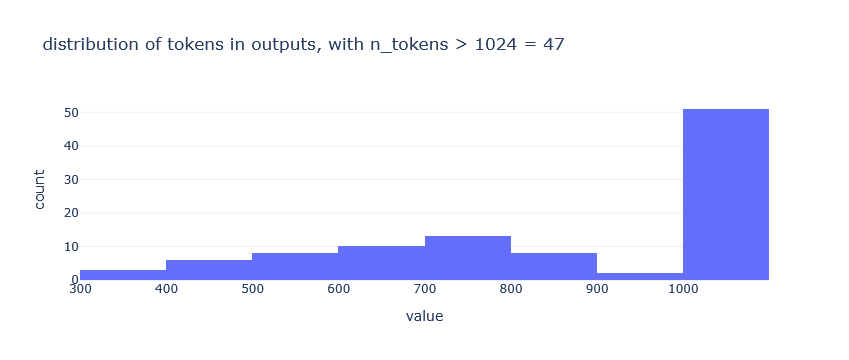

In [21]:
fig = px.histogram(model2_tokens, title=f"distribution of tokens in outputs, with n_tokens > 1024 = {exceeded_2}")
fig.update_layout(showlegend=False, template="plotly_white")
fig

In [37]:
# max tokens generated for models we have seen so far.
max(model0_tokens), max(model1_tokens), max(model2_tokens)

(1538, 1054, 1075)

# Load Data

we would now be evaluting the outputs generated by our base-model and fine-tuned models

In [12]:
# load the ground truth / reference data and unpack the outputs

model0_outputs = loads(base_outputs.read_text())
model1_outputs = loads(custom_outputs.read_text())
model2_outputs = loads(combined_outputs.read_text())

custom_dataset = load_jsonl(custom_dataset_file)
split_dataset = split_90_and_10(custom_dataset)
test_dataset = split_dataset["test"]

print(f"✓ Loaded {len(test_dataset)} examples")

# Extract the gpt 5.1 outputs
reference = []
for i in test_dataset:
    reference.append(i["messages"][2]["content"])


[1/8] Loading dataset...
✓ Loaded 1004 examples
✓ Train: 903 | Val: 101
✓ Loaded 101 examples


## Evaluation

we would be evaluating the results we received from the model with reference results we got from gpt5.1 agent and see our model's performance based on it

In [3]:
p, r, zeroF1 = evaluate(model0_outputs, reference, device = "mps")
p, r, oneF1 = evaluate(model1_outputs, reference, device = "mps")
p, r, twoF1 = evaluate(model2_outputs, reference, device = "mps")
# we evaluate the results from each models, we only need their f1 scores

In [4]:
zeroF1 = np.array(zeroF1)
oneF1 = np.array(oneF1)
twoF1 = np.array(twoF1)
print(np.mean(zeroF1), np.mean(oneF1), np.mean(twoF1))

0.644637 0.69716775 0.68390054


/var/folders/5z/ksmd9z810hv7hd63k2mmtgzr0000gn/T/ipykernel_15258/2522561554.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  zeroF1 = np.array(zeroF1)
/var/folders/5z/ksmd9z810hv7hd63k2mmtgzr0000gn/T/ipykernel_15258/2522561554.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  oneF1 = np.array(oneF1)
/var/folders/5z/ksmd9z810hv7hd63k2mmtgzr0000gn/T/ipykernel_15258/2522561554.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing cop

# Visualizing the Scores

now that we have our evalution scores, we will plot boxplot & histogram to see the distribution of the scores across samples

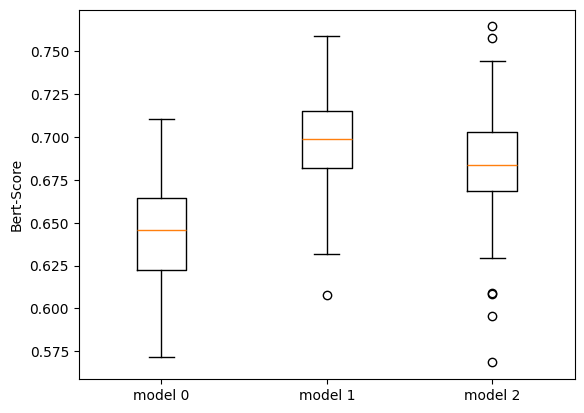

In [13]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([zeroF1, oneF1, twoF1])
ax.set_xticklabels(["model 0", "model 1", "model 2"]) 
ax.set_ylabel("Bert-Score") 
plt.show()

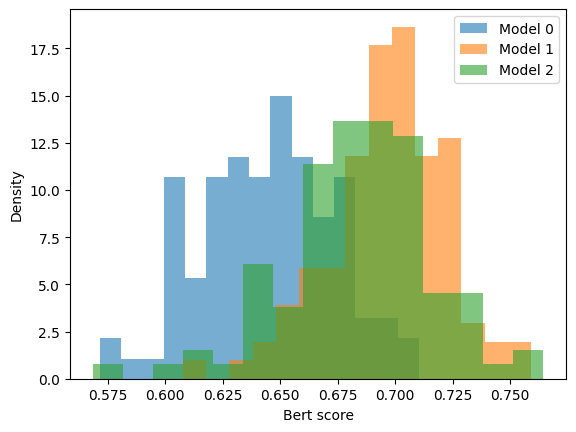

In [14]:
fig, ax = plt.subplots()

ax.hist(zeroF1, bins=15, alpha=0.6, label="Model 0", density=True)
ax.hist(oneF1, bins=15, alpha=0.6, label="Model 1", density=True)
ax.hist(twoF1, bins=15, alpha=0.6, label="Model 2", density=True)

ax.set_xlabel("Bert score")
ax.set_ylabel("Density")
ax.legend()

plt.show()


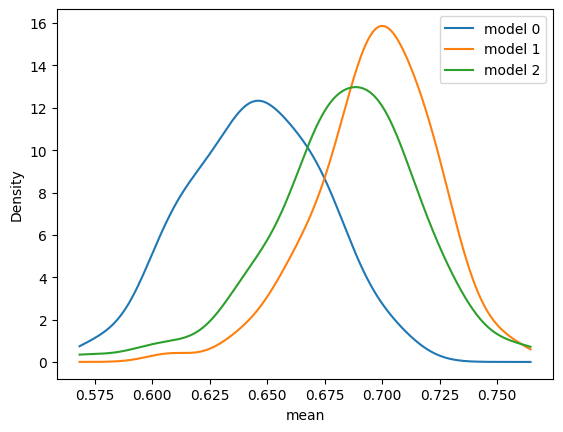

In [7]:
fig, ax = plt.subplots()

x = np.linspace(
    min(zeroF1.min(), oneF1.min(),  twoF1.min()),
    max(zeroF1.max(), oneF1.max(), twoF1.max()),
    500
)

ax.plot(x, gaussian_kde(zeroF1)(x), label="model 0")
ax.plot(x, gaussian_kde(oneF1)(x), label="model 1")
ax.plot(x, gaussian_kde(twoF1)(x), label="model 2")

ax.set_xlabel("mean")
ax.set_ylabel("Density")
ax.legend()

plt.show()


In [8]:
res = tukey_hsd(zeroF1, oneF1, twoF1)
print(res)

Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.053     0.000    -0.062    -0.043
 (0 - 2)     -0.039     0.000    -0.049    -0.030
 (1 - 0)      0.053     0.000     0.043     0.062
 (1 - 2)      0.013     0.004     0.004     0.023
 (2 - 0)      0.039     0.000     0.030     0.049
 (2 - 1)     -0.013     0.004    -0.023    -0.004

